In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
tf.compat.v1.disable_eager_execution()

In [3]:
from keras.models import load_model

path='./model/keras_1000.h5'

model = load_model(path)

In [4]:
import numpy as np

x_test=np.load('./raw_data/x_test.npy')
y_test=np.load('./raw_data/y_test.npy')

print(x_test.shape)
print(y_test.shape)


(1350, 58)
(1350,)


In [5]:
from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import KerasClassifier

d:\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
art_classifier = KerasClassifier(model=model, use_logits=False)

OHE_benign =  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0,  0]

targets=[]

for i in range(0,len(x_test)):
  targets.append(OHE_benign)
numpy_targets = np.array(targets)

# Theta = perturbation to each feature
# Gamma = float max fraction of features being perturbed
for theta in ([0.06]):
  for gamma in ([0.03]):

    attack = SaliencyMapMethod(classifier=art_classifier, theta=theta, gamma=gamma, batch_size=1,verbose=True) # Theta = Small Perturbation , Gamma = 10% of features
    
    print("Starting to Generate untargeted JSMA")
    x_test_jsma = attack.generate(x=x_test)

    print("Starting to Generate Targeted JSMA")
    targeted_benign_x_test_jsma = attack.generate(x=x_test,y=numpy_targets)

    #Keep benign cases
    for i in range(0,len(x_test)):
      if(y_test[i] == 0):
        x_test_jsma[i] = x_test[i]
        targeted_benign_x_test_jsma[i] = x_test[i]

    basedir='./raw_data/adversial_samples/'

    # Save x_test_jsma 
    savename='x_test_jsma-' + 'theta-' + str(theta) + 'gamma-'+ str(gamma) +'.npy'
    filename=basedir+savename
    print(f"Writing file {filename}")
    np.save(filename, x_test_jsma)

    savename='targeted_benign_jsma-'+ 'theta-' + str(theta) + 'gamma-'+ str(gamma) +'.npy'
    filename=basedir+savename
    print(f"Writing file {filename}")
    np.save(filename, targeted_benign_x_test_jsma)

Starting to Generate untargeted JSMA


JSMA: 100%|██████████| 1350/1350 [00:02<00:00, 452.32it/s]


Starting to Generate Targeted JSMA


JSMA: 100%|██████████| 1350/1350 [00:02<00:00, 608.96it/s]

Writing file ./raw_data/x_test_jsma-theta-0.06gamma-0.03.npy
Writing file ./raw_data/targeted_benign_jsma-theta-0.06gamma-0.03.npy


In [14]:
from sklearn.metrics import classification_report

predictions = model.predict(targeted_benign_x_test_jsma)

rounded_predictions = predictions * 100 

# rounded_predictions = predictions.round().astype(int)
integer_predictions = []

for i in range(len(rounded_predictions)):

  arr = [rounded_predictions[i][0], rounded_predictions[i][1], rounded_predictions[i][2], 
        rounded_predictions[i][3], rounded_predictions[i][4], rounded_predictions[i][5], 
        rounded_predictions[i][6], rounded_predictions[i][7], rounded_predictions[i][8],
        rounded_predictions[i][9], rounded_predictions[i][10], rounded_predictions[i][11],
        rounded_predictions[i][12], rounded_predictions[i][13], rounded_predictions[i][14],
        ]

  # print(arr)
  HighestProbabilityClass = arr.index(max(arr))
  # print(HighestProbabilityClass)
  integer_predictions.append(HighestProbabilityClass)

print(classification_report(integer_predictions,y_test))

              precision    recall  f1-score   support

           0       0.71      0.10      0.18       709
           1       0.07      0.04      0.05       154
           2       0.00      0.00      0.00        19
           3       0.04      0.67      0.08         6
           4       0.04      0.40      0.07        10
           5       0.20      0.27      0.23        67
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        48
           8       1.00      1.00      1.00        97
           9       0.81      0.35      0.49       211
          10       0.01      0.20      0.03         5
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         3

    accuracy                           0.20      1350
   macro avg       0.19      0.20      0.14      1350
weighted avg       0.59   

d:\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


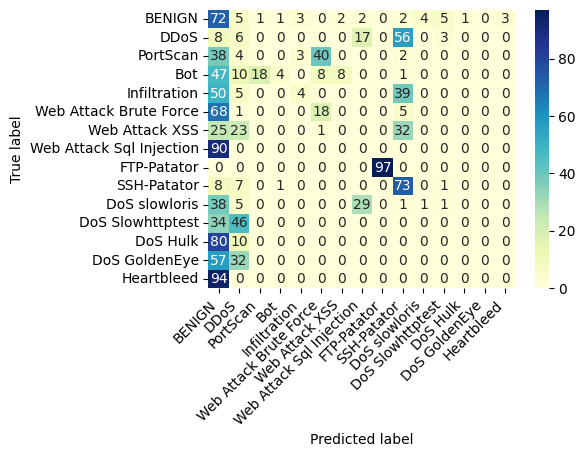

In [15]:
from sklearn.metrics import confusion_matrix

conf_mat=confusion_matrix(y_test,integer_predictions)
classlabel=['BENIGN','DDoS' ,'PortScan', 'Bot', 'Infiltration',
 'Web Attack Brute Force', 'Web Attack XSS',
 'Web Attack Sql Injection', 'FTP-Patator' ,'SSH-Patator' ,'DoS slowloris',
 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye' ,'Heartbleed']
df_cm=pd.DataFrame(conf_mat,index=classlabel,columns=classlabel)
heatmap=sns.heatmap(df_cm,annot=True,fmt='d',cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),rotation=0,ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.gcf().subplots_adjust(left=0.3, bottom=0.3)
plt.show()